In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
os.chdir('/content/drive/MyDrive/Master Thesis/src')
from mnist_utils import load_and_transform_mnist, transform_labels_to_binary
from trainers import *
from plots import *

In [4]:
os.chdir('/content/drive/MyDrive/Master Thesis')

MNIST_PATH = '/content/drive/MyDrive/datasets'
RESULTS_PATH = os.path.join(os.path.join(os.getcwd(), "results"), "layers=3 relu classes=[6,8]")

In [5]:
new_dim = 10
keep_classes = [6,8]

criterion = nn.BCELoss()

def get_net():
    return nn.Sequential(
        nn.Linear(new_dim,5),
        nn.ReLU(),
        nn.Linear(5,5),
        nn.ReLU(),
        nn.Linear(5,1),
        nn.Sigmoid()
    )

def get_dataset():
    dataset = load_and_transform_mnist(MNIST_PATH, new_dim, keep_classes)
    # the following needed specifically for BCELoss
    dataset["train_targets"] = dataset["train_targets"][..., None].float()
    dataset["test_targets"] = dataset["test_targets"][..., None].float()
    return dataset

In [6]:
def print_negative_psdness(trainer_):
    iters, psd_ness = get_psd_ness(trainer_)
    for i, psd in zip(iters, psd_ness):
        if psd < 0:
            iter_id = trainer_.metrics["iter"].index(i)
            hess_iter_id = trainer_.hessian_metrics["iter"].index(i-1) # cause we computer lambda_n after previous step
            lambda_n = trainer_.hessian_metrics["lambda_n"][hess_iter_id]
            M = trainer_.metrics["M"][iter_id]
            r = trainer_.metrics["step_size"][iter_id]
            print(f"iter = {iter_id}: lambda_n = {lambda_n}, M = {M}, r = {r}, lambda_n + M*r/2 = {psd}")

# Cubic Newton

In [16]:
CN_trainer = {}

for M_min in [3e0, 1e0, 3e-1, 1e-1, 1e-2]:
    seed = 0
    max_iters = 120
    print_every = 10
    eval_every = 1
    eval_hessian_every = 1
    save_spectrum_every = 10
    save_hessian_every = 20
    save_every = max_iters
    weight_decay = 0.
    # kwargs
    M = 1.0

    model_dir = os.path.join(os.path.join(RESULTS_PATH, "CN"), f"seed={seed} M_min={M_min}")
    print(f"model_dir: {model_dir}")

    torch.manual_seed(seed)
    CN_trainer[M_min] = AdaptiveCubicNewtonTrainer(get_net(), get_dataset(), criterion, weight_decay, model_dir, M,  M_min)
    CN_trainer[M_min].load()
    print_training_stats(CN_trainer[M_min], print_every)
    #_ = CN_trainer[M_min].train(max_iters, print_every, eval_every, eval_hessian_every, save_spectrum_every, save_hessian_every, save_every)

model_dir: /content/drive/MyDrive/Master Thesis/results/layers=3 relu classes=[6,8]/CN/seed=0 M_min=3.0
     0: train loss =  0.678533, test loss =  0.682290, M =   1.00000000, time =    0.00 sec, lambda_n = -0.645851
    10: train loss =  0.055103, test loss =  0.056929, M =   3.00000000, time =    1.67 sec, lambda_n = -0.014645
    20: train loss =  0.046705, test loss =  0.047355, M =   3.00000000, time =    3.33 sec, lambda_n = -0.003607
    30: train loss =  0.039825, test loss =  0.040652, M =   3.00000000, time =    4.99 sec, lambda_n = -0.001888
    40: train loss =  0.037218, test loss =  0.037278, M =   3.00000000, time =    6.95 sec, lambda_n = -0.000937
    50: train loss =  0.036169, test loss =  0.035576, M =   3.00000000, time =    8.90 sec, lambda_n = -0.000962
    60: train loss =  0.035512, test loss =  0.033973, M =   3.00000000, time =   11.04 sec, lambda_n = -0.003008
    70: train loss =  0.034296, test loss =  0.031718, M =   3.00000000, time =   12.69 sec, lambd

In [17]:
min(CN_trainer[1e-2].metrics["M"])

0.03125

In [18]:
print_test_accuracy(CN_trainer[1e-2])

Best test accuracy: 98.96%
Last test accuracy: 98.91%


In [19]:
print_test_accuracy(CN_trainer[1e-1])

Best test accuracy: 98.96%
Last test accuracy: 98.86%


In [20]:
print_test_accuracy(CN_trainer[3e-1])

Best test accuracy: 99.02%
Last test accuracy: 98.96%


In [21]:
print_test_accuracy(CN_trainer[1e0])

Best test accuracy: 99.17%
Last test accuracy: 98.96%


In [22]:
print_test_accuracy(CN_trainer[3e0])

Best test accuracy: 99.12%
Last test accuracy: 99.02%


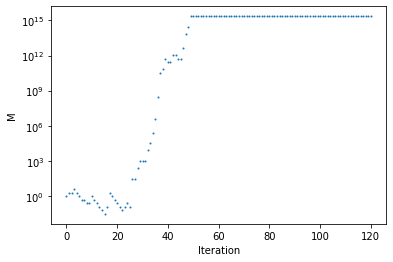

In [23]:
plot_M(CN_trainer[1e-2])

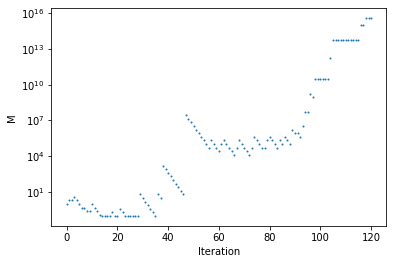

In [24]:
plot_M(CN_trainer[1e-1])

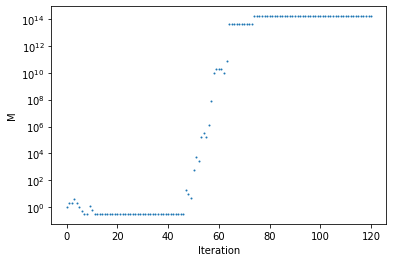

In [25]:
plot_M(CN_trainer[3e-1])

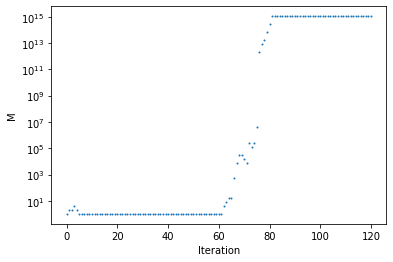

In [26]:
plot_M(CN_trainer[1e0])

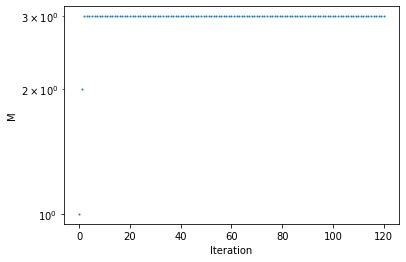

In [27]:
plot_M(CN_trainer[3e0])

min eigenvalue of (H + Mr/2*I) over all observed iterations: -0.00073173


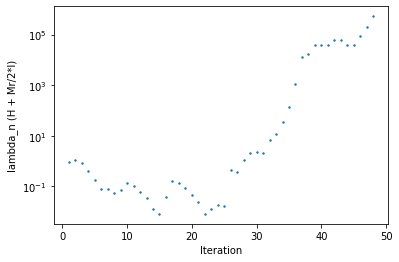

In [28]:
plot_psd_ness(CN_trainer[1e-2])

In [30]:
#print_negative_psdness(CN_trainer[1e-2])

min eigenvalue of (H + Mr/2*I) over all observed iterations: -0.00100007


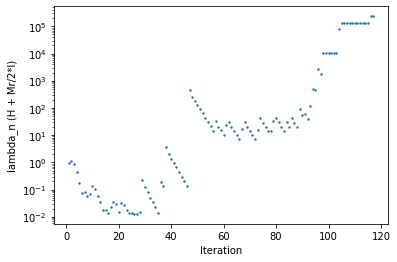

In [31]:
plot_psd_ness(CN_trainer[1e-1])

min eigenvalue of (H + Mr/2*I) over all observed iterations: -0.00041583


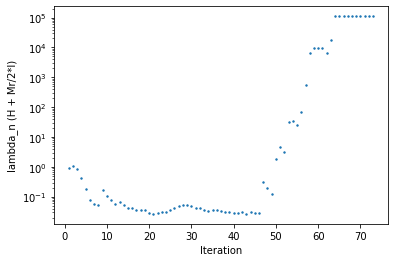

In [32]:
plot_psd_ness(CN_trainer[3e-1])

min eigenvalue of (H + Mr/2*I) over all observed iterations: -0.00060180


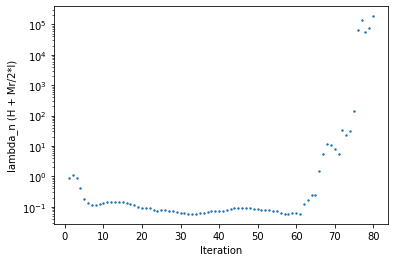

In [33]:
plot_psd_ness(CN_trainer[1e0])

min eigenvalue of (H + Mr/2*I) over all observed iterations:  0.08388700


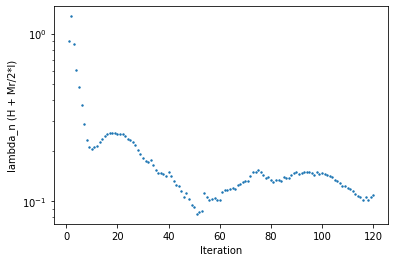

In [34]:
plot_psd_ness(CN_trainer[3e0])

In [1]:
#visualize_spectrum_evolution(CN_trainer[1e-2], plot_every_iter=1, bin_size=0.1, y_range=(0, 90))

In [2]:
#visualize_spectrum_evolution(CN_trainer[1e-1], plot_every_iter=1, bin_size=0.1, y_range=(0, 90))

In [3]:
#visualize_spectrum_evolution(CN_trainer[3e-1], plot_every_iter=1, bin_size=0.1, y_range=(0, 90))

In [4]:
#visualize_spectrum_evolution(CN_trainer[1e0], plot_every_iter=1, bin_size=0.1, y_range=(0, 90))

In [5]:
#visualize_spectrum_evolution(CN_trainer[3e0], plot_every_iter=1, bin_size=0.1, y_range=(0, 90))

In [6]:
#visualize_hessians_evolution(CN_trainer[1e-2], plot_every_iter=1)

In [7]:
#visualize_hessians_evolution(CN_trainer[1e-1], plot_every_iter=1)

In [8]:
#visualize_hessians_evolution(CN_trainer[3e-1], plot_every_iter=1)

In [9]:
#visualize_hessians_evolution(CN_trainer[1e0], plot_every_iter=1)

In [10]:
#visualize_hessians_evolution(CN_trainer[3e0], plot_every_iter=1)

# plot (Cubic Newton versions)

In [40]:
metrics = []
hessian_metrics = []
labels = []

for M_min in [1e-2, 1e-1, 3e-1, 1e0, 3e0]:
    metrics.append(get_metrics(CN_trainer[M_min]))
    hessian_metrics.append(get_hessian_metrics(CN_trainer[M_min]))
    labels.append(f"M_min={M_min}")

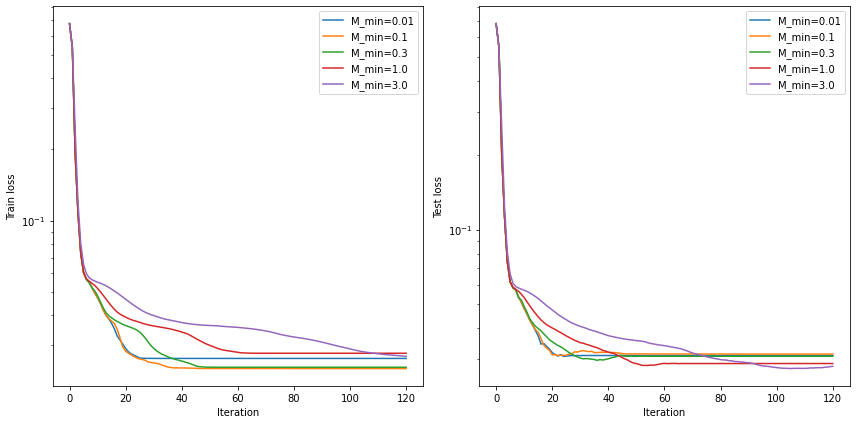

In [41]:
plot_losses(metrics, labels)

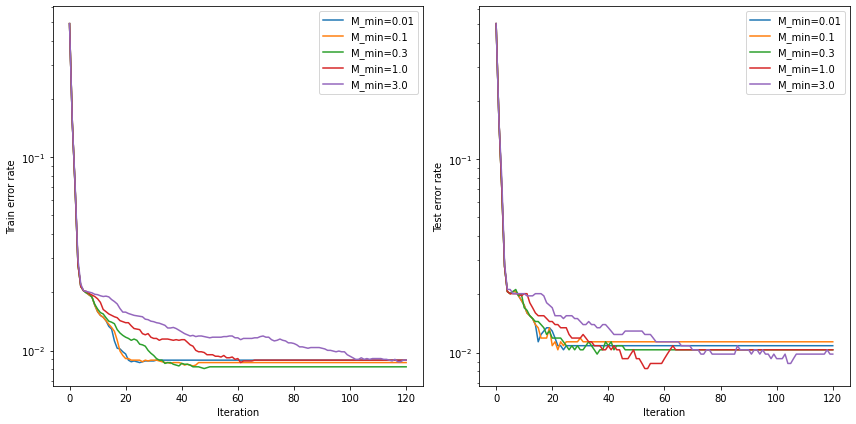

In [42]:
plot_errors(metrics, labels)

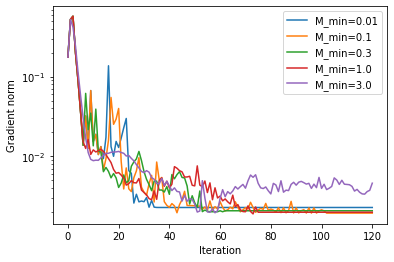

In [43]:
plot_grad_norms(metrics, labels)

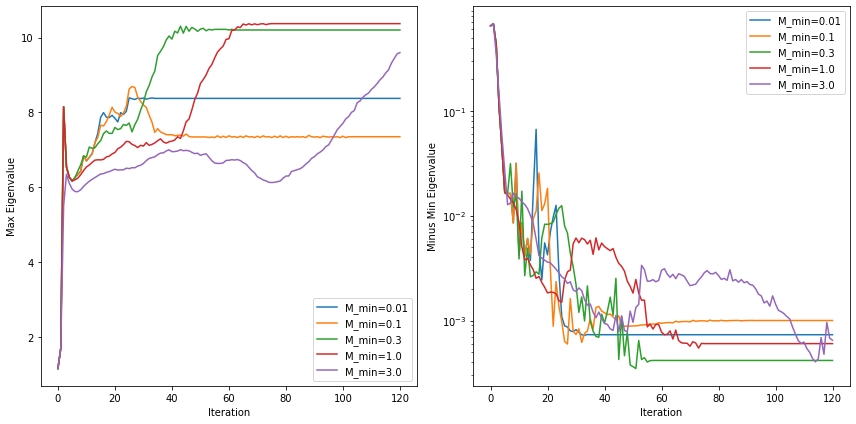

In [44]:
plot_max_min_eigvals(hessian_metrics, labels)

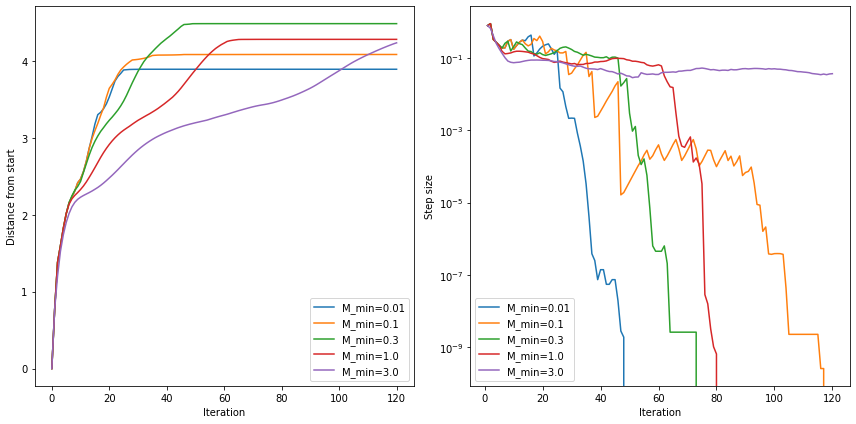

In [45]:
plot_distances(metrics, labels)

# Gradient Descent

In [46]:
seed = 0
max_iters = 1400
print_every = 100
eval_every = 10
eval_hessian_every = 50
save_spectrum_every = 200
save_hessian_every = None
save_every = max_iters
weight_decay = 0.
# kwargs
L = 1.0
L_min = 1e-3

model_dir = os.path.join(os.path.join(RESULTS_PATH, "GD"), f"seed={seed} L_min={L_min}")
print(f"model_dir: {model_dir}")

torch.manual_seed(seed)
GD_trainer = AdaptiveGDTrainer(get_net(), get_dataset(), criterion, weight_decay, model_dir, L, L_min)
GD_trainer.load()
print_training_stats(GD_trainer, print_every)
#_ = GD_trainer.train(max_iters, print_every, eval_every, eval_hessian_every, save_spectrum_every, save_hessian_every, save_every)

model_dir: /content/drive/MyDrive/Master Thesis/results/layers=3 relu classes=[6,8]/GD/seed=0 L_min=0.001
     0: train loss =  0.678533, test loss =  0.682290, L =   1.00000000, time =    0.00 sec, lambda_n = -0.645851
   100: train loss =  0.052518, test loss =  0.054901, L =   4.00000000, time =    0.68 sec, lambda_n = -0.013019
   200: train loss =  0.045129, test loss =  0.047151, L =   4.00000000, time =    1.34 sec, lambda_n = -0.005068
   300: train loss =  0.038590, test loss =  0.041248, L =   2.00000000, time =    1.96 sec, lambda_n = -0.006185
   400: train loss =  0.035255, test loss =  0.038166, L =   2.00000000, time =    2.62 sec, lambda_n = -0.005493
   500: train loss =  0.033103, test loss =  0.036345, L =   2.00000000, time =    3.25 sec, lambda_n = -0.003398
   600: train loss =  0.031782, test loss =  0.035106, L =   4.00000000, time =    3.91 sec, lambda_n = -0.002331
   700: train loss =  0.030948, test loss =  0.034254, L =   2.00000000, time =    4.55 sec, lam

In [47]:
print_test_accuracy(GD_trainer)

Best test accuracy: 98.81%
Last test accuracy: 98.81%


In [11]:
#visualize_spectrum_evolution(GD_trainer, y_range=(0, 90), bin_size=0.1)

# SGD

In [48]:
seed = 0
max_iters = 1500
print_every = 100
eval_every = 10
eval_hessian_every = 50
save_spectrum_every = 200
save_hessian_every = None
save_every = max_iters
weight_decay =0.
# kwargs
optim_class = torch.optim.SGD
optim_params = {'lr': 0.1}
dataset = get_dataset()
batch_size = 64

model_dir = os.path.join(os.path.join(RESULTS_PATH, "GD with momentum"), f"seed={seed} lr={optim_params['lr']}, batch_size={batch_size}")
print(f"model_dir: {model_dir}")

torch.manual_seed(seed)
SGD_trainer = CustomTrainer(get_net(), get_dataset(), criterion, weight_decay, model_dir, optim_class, optim_params, batch_size)
SGD_trainer.load()
print_training_stats(SGD_trainer, print_every)
#_ = SGD_trainer.train(max_iters, print_every, eval_every, eval_hessian_every, save_spectrum_every, save_hessian_every, save_every)

model_dir: /content/drive/MyDrive/Master Thesis/results/layers=3 relu classes=[6,8]/GD with momentum/seed=0 lr=0.1, batch_size=64
     0: train loss =  0.678533, test loss =  0.682290, time =    0.00 sec, lambda_n = -0.645851
   100: train loss =  0.070866, test loss =  0.067234, time =    0.07 sec, lambda_n = -0.153009
   200: train loss =  0.057678, test loss =  0.058587, time =    0.15 sec, lambda_n = -0.015658
   300: train loss =  0.056286, test loss =  0.055891, time =    0.22 sec, lambda_n = -0.024497
   400: train loss =  0.055650, test loss =  0.059803, time =    0.29 sec, lambda_n = -0.048817
   500: train loss =  0.054892, test loss =  0.053755, time =    0.36 sec, lambda_n = -0.049287
   600: train loss =  0.060289, test loss =  0.055722, time =    0.43 sec, lambda_n = -0.139836
   700: train loss =  0.051480, test loss =  0.054866, time =    0.50 sec, lambda_n = -0.019556
   800: train loss =  0.054293, test loss =  0.059658, time =    0.57 sec, lambda_n = -0.107095
   900

In [49]:
print_test_accuracy(SGD_trainer)

Best test accuracy: 98.45%
Last test accuracy: 98.29%


In [12]:
#visualize_spectrum_evolution(SGD_trainer, y_range=(0,90), bin_size=0.1)

# Plots

In [50]:
metrics = [get_metrics(CN_trainer[1e0]), get_metrics(GD_trainer), get_metrics(SGD_trainer)]
hessian_metrics = [get_hessian_metrics(CN_trainer[1e0]), get_hessian_metrics(GD_trainer), get_hessian_metrics(SGD_trainer)]
labels = ["CN", "GD", "SGD"]

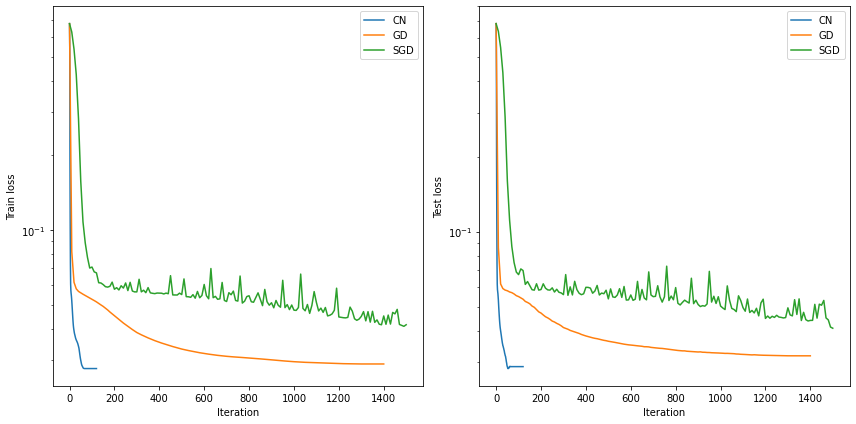

In [51]:
plot_losses(metrics, labels)

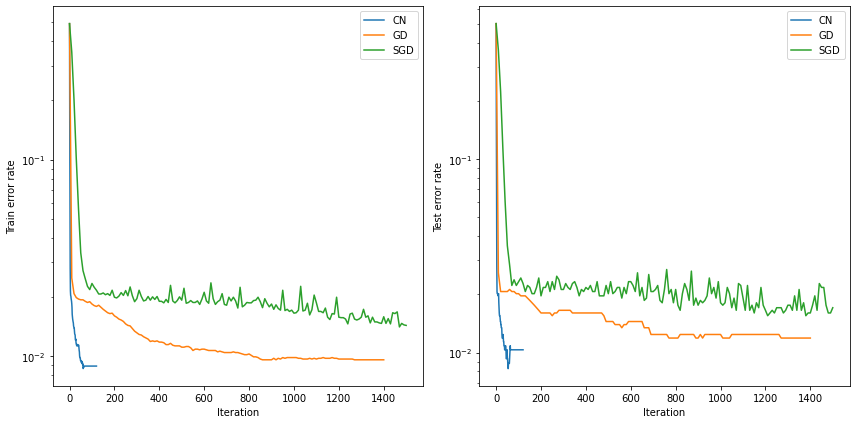

In [52]:
plot_errors(metrics, labels)

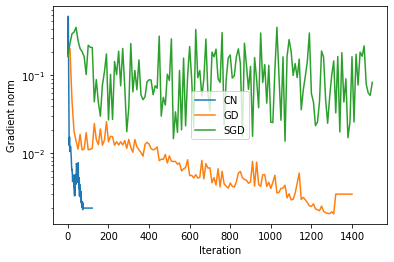

In [53]:
plot_grad_norms(metrics, labels)

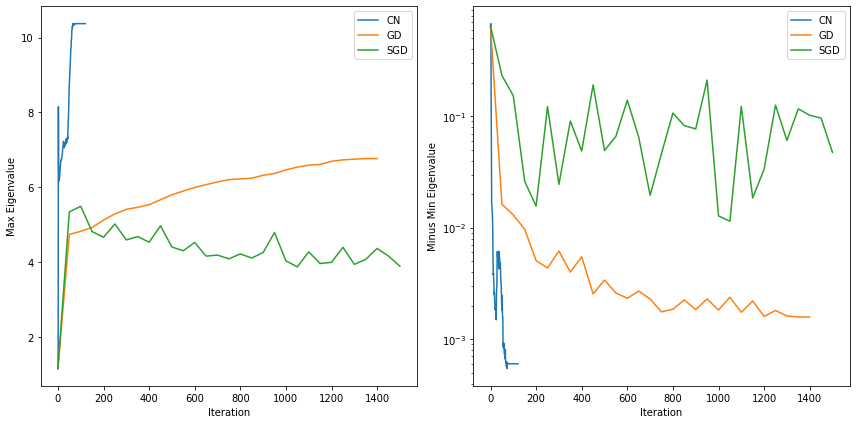

In [54]:
plot_max_min_eigvals(hessian_metrics, labels)

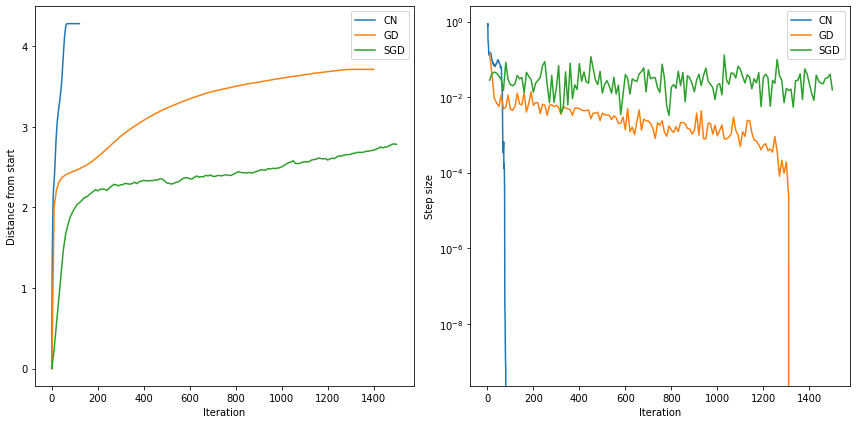

In [55]:
plot_distances(metrics, labels)